# Assignment group 3: Probabilistic modeling and prediction

#### Kiana Montazeri

## Module A _(55 pts)_ Optimizing for predicted separation
__Data.__ For this module we'll be working with the basic baseball player heights and weights from the lecture notes. These are packaged in the following location:

- `"./data/baseball_heightweight.csv"`

__Overview.__ The purpose of this module is to provide experience with optimization and to view/investigate a different optimizable functions (from error). In the __Chapter 5.__ lecture notes we investigated the sum of squared errors as a function of (linear) model parameters. This made the goal of optimization (executed through gradient descent) into a 'fitting' procedure, i.e., describing a pattern that data follow.

Another way we can use a line is as a 'separator': supposing some data $x_1, \cdots, x_n$ have labels $y_1, \cdots, y_n$ falling into two classes (coded as $\pm 1$), which set of line-defining $w$ and $b$ parameters separate the points the best. Check out the picture  below for an intution (note: their $b$ is our $-b$).

Note: even though we're talking about 'lines', and actually working with true, 2-dimensional lines throughout this module, it's important to think/code throughout this module with the expectation that each data point $x_i$ will have $m$ (potentially greater than 2) dimensions. When $m>3$, a 'line' technically refers to a plane, but after we leave the comfort of 3-dimensionality our 'lines' are technically _hyperplanes_, for which we have little experiential intuition. Hence, we'll adopt the terminology 'line' throughout, since this provides the strongest grounding of intuition.

![SVM Margin](./images/SVM_margin.png)

In [1]:
#Libraries in use:
from pprint import pprint
from collections import Counter
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

__A1.__ _(7 pts_) To get things started: 

1. load the baseball player data with pandas into a dataframe called `bball`;
2. filter `bball` to contain only those rows that correspond to shortstops and catchers;
3. create an `.array()` called `y_bball` of labels, containing a `1` for each catcher and a `-1` for each shortstop;
4. filter the remaining rows of `bball` to only the `Height` and `Weight` columns; and
5. standardize the columns of `bball` and exhibit the first 10 rows.

In [2]:
bball = pd.read_csv("./data/baseball_heightweight.csv", header = 0)
bball.head(2)

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69


In [3]:
bball["Position"].unique()

array(['Catcher', 'First_Baseman', 'Second_Baseman', 'Shortstop',
       'Third_Baseman', 'Outfielder', 'Designated_Hitter',
       'Starting_Pitcher', 'Relief_Pitcher'], dtype=object)

In [4]:
bball_filtered = bball[(bball["Position"] == "Catcher") | (bball["Position"] == "Shortstop")] #filter positions

In [5]:
bball_filtered.head()

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
6,Miguel_Tejada,BAL,Shortstop,69,209.0,30.77
35,A.J._Pierzynski,CWS,Catcher,75,245.0,30.17


In [6]:
#make an array of 1 for catchers and -1 for shortstops
y_bball = np.array(bball_filtered['Position'])
y_bball[y_bball == "Catcher"] = 1
y_bball[y_bball == "Shortstop"] = -1
print(y_bball)

[1 1 1 -1 1 1 -1 -1 1 1 1 -1 -1 1 1 1 -1 -1 1 1 -1 1 1 1 -1 -1 -1 1 1 -1 1
 1 -1 -1 -1 1 1 -1 -1 1 1 1 -1 1 1 -1 -1 1 1 1 1 -1 -1 1 1 -1 -1 1 1 1 -1
 1 1 -1 -1 1 1 1 -1 1 1 -1 -1 1 1 -1 -1 1 1 1 -1 -1 1 1 1 -1 -1 1 1 -1 -1
 1 1 1 -1 1 1 -1 1 1 1 1 -1 1 1 1 1 -1 -1 -1 1 1 -1 -1 1 1 -1 -1 -1 1 1 -1
 1 1 -1 1 1 -1]


In [7]:
bball_selected = bball_filtered[["Height", "Weight"]] #select columns

In [8]:
bball_selected.head(2)

,Height,Weight
0,74,180.0
1,74,215.0


In [9]:
def standardize(df):
    stand_df = (df-df.mean())/df.std()
    return stand_df

In [10]:
std_bball = standardize(bball_selected)
std_bball.head(10)

,Height,Weight
0,0.886600,-0.845114
1,0.886600,1.046996
2,-0.215194,0.776694
6,-1.867885,0.722634
35,1.437497,2.668804
36,1.437497,2.398502
39,-0.766091,-1.115416
40,0.886600,0.182031
68,0.886600,1.317297
69,-0.215194,-0.845114


__A2.__ _(5 pts)_ Since our goal with this problem will be to draw a line that separates the catchers from the shortstops, write and execute a function called 

- `plot_data_boundary(data, y)` 

that creates a scatter plot of the standardized heights and weights where the points are color coded with shortstops as black circles and catchers as red squares. In the response box below, disucss how well you think a line can separate these data.

<font color=blue>We can see a border between these two categories but there is a lot of overlap as well. Maybe a polynomial curve can seperate them better than a straight line.</font>

In [11]:
def plot_data_boundary(data, y):
    #initialize the plot:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_title("Standard Weight Vs. Height",fontsize=14)
    ax.set_xlabel("Height", fontsize=12)
    ax.set_ylabel("Weight", fontsize=12)
    ax.grid(True, linestyle='--', color = '0.75')
    ###################################################
    #make the colors and markers:
    colors= ['red' if l == 1 else 'black' for l in y]
    marker = [u"s" if l == 1 else u"o" for l in y]
    ###################################################
    x_ = data['Height']
    y_ = data['Weight']
    ###################################################
    for mark, col, _x, _y in zip(marker, colors, x_, y_):
        plt.scatter(_x, _y, marker = mark, c = col)
    return 

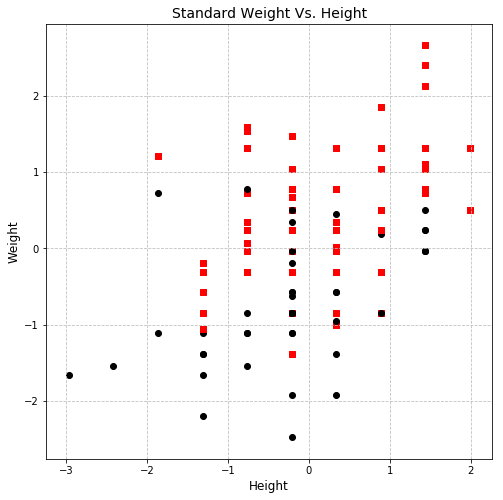

In [12]:
plot_data_boundary(std_bball, y_bball)

__A3.__ _(5 pts)_ The way we'll be drawing lines (hyperplanes) in this problem uses what's called the 'standard form'. Supposing we have vectors (rows) of features (columns) $x = [x_1, \cdots, x_m]$, a linear relationship is defined by a vector of weights $w = [w_1,\cdots,w_m]$ and an intercept $b$ in the form:
$$
w\cdot x + b = 0
$$
Since our data only has two columns, we can re-arrange into slope-intercept form:
$$
x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}
$$
to conveniently plot a line in standard form. 

So, modify your `plot_data_boundary()` function to accept a `w` (a vector) and `b` (a scalar) arguments and plot the corresponding line over the range of $x_1$ values using the slope-intercept form above. 

When complete, select you own $w$ and $b$ parameters and use your function to exhibit a corresponding line over the problem's data. Then, disucuss how well the line separates the two (catcher and shortstop) classes in the response box below.

<font color=blue>The line works pretty well in seperating the two categories although there are multiple errors in both catcher and Shortstop groups. However, it is not possible to seperate the two groups completely with a single line.</font> 

In [13]:
def modified_plot_data_boundary(data, y, w, b):
    plot_data_boundary(data, y)
    #######################################################
    #define the slope and intercept:
    intercept = -b / w[1]
    slope = -w[0] / w[1]
    #######################################################
    #calculate x and y for the line:
    x_ = data['Height']
    xx = np.linspace(1.1*x_.min(), 1.1*x_.max())#set the limit for the line
    yy = (slope * xx) + intercept
    #######################################################
    #plot the line
    plt.plot(xx, yy, 'k-', c = 'b')
    return

#### Pick a value for w and b:

In [47]:
w = np.array([0.8, 1])
b = 0.85

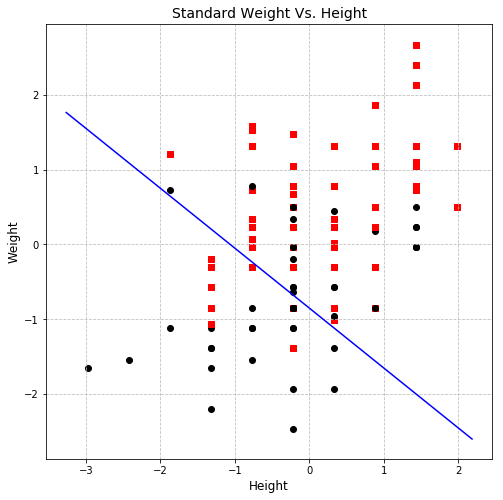

In [48]:
modified_plot_data_boundary(std_bball, y_bball, w, b)

__A4.__ _(3 pts)_ Now, for any point $x$ on the line defined by $w$ and $b$, the following relationship holds:
$$
w\cdot x + b = 0
$$

But our points probably don't lie exactly on a line. To tell which sides of the line they fall on, we can just look at the sign the left hand side of the equation above:

- $x$ is above the line:
    - $\hat{y} = w\cdot x_i + b > 0$ 
- $x$ is below the line:
    - $\hat{y} = w\cdot x_i + b < 0$

What we're hoping to do is have all $x$'s either have $y,\hat{y} < 0$ or $y,\hat{y} > 0$. One way to test if a point is 'correctly' separated is if $y\hat{y} > 0$, so use this test ($y\hat{y} > 0$ means 'separated') to write a function called 
- `separated(data, y, w, b)`

that outputs a boolean mask of $n$ values where `True` corresponds to a point falling on the correct side of the line ($y\hat{y} > 0$). When this is done, use your functon to calculate/report the percent of points your line correctly separated below.

In [49]:
def separated(data, y, w, b):
    x_ = data['Height']
    y_ = data['Weight']
    #calulate y_hat
    y_hat = (w.dot(np.array([x_, y_]))) + b
    #make the mask
    y_mask = y*y_hat >= 0 
    return list(y_mask)

In [50]:
y_mask = separated(std_bball, y_bball, w, b)

In [51]:
print(y_mask)

[True, True, True, False, True, True, True, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, False, False, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, False, False, False, False, True, True, False, False, True, True, False, False, False, True, True, False, True, True, True, True, True, True]


In [52]:
print("Percentage of correctly seperated points: \n")
print(100*sum(y_mask)/len(y_mask))

Percentage of correctly seperated points: 

69.53125


__A5.__ _(3 pts)_ Now that we have our `separated()` function, use it to modify your `plot_data_boundary()` function into a new one called:
- `plot_separated(data, y, w, b)`

which plots the same points and line as before, but now color codes them for _correctness of separation_ as well label. In particular, organize your points as follows:
- indicate correctly separated negative points (catchers) with black circles, 
- indicate incorrectly separated positive points (catchers) with green triangles, 
- indicate correctly separated positive points (shortstops) with red squares, and
- indicate incorrectly separated negative points (shortstops) with yellow diamonds.

In [53]:
def plot_separated(data, y, w, b):
    #get the boolean mask from seperated function
    y_mask = separated(data, y, w, b)
    #initialize the plot:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_title("Standard Weight Vs. Height",fontsize=14)
    ax.set_xlabel("Height", fontsize=12)
    ax.set_ylabel("Weight", fontsize=12)
    ax.grid(True, linestyle='--', color = '0.75')
    ########################################Modified section:#######################
    #make the colors and markers:
    colors= ['red' if l == 1 else 'black' for l in y]
    marker = [u"s" if l == 1 else u"o" for l in y]
    for i, mask in enumerate(y_mask):
        if mask:
            pass
        else:
            if colors[i] == "red":           
                colors[i] = "yellow"
                marker[i] = u"D"
            elif colors[i] == "black":           
                colors[i] = "green"
                marker[i] = u"^"
    ###################################rest is the same as before###################
    #define x and y of the data
    x_ = data['Height']
    y_ = data['Weight']
    #define the slope and intercept:
    intercept = -b / w[1]
    slope = -w[0] / w[1]
    #calculate x and y for the line:
    xx = np.linspace(1.1*data['Height'].min(), 1.1*data['Height'].max())
    yy = (slope * xx) + intercept
    #plot data points:
    for mark, col, _x, _y in zip(marker, colors, x_, y_):
        plt.scatter(_x, _y, marker = mark, c = col)
    #plot the line
    plt.plot(xx, yy, 'k-', c = 'b')
    return 

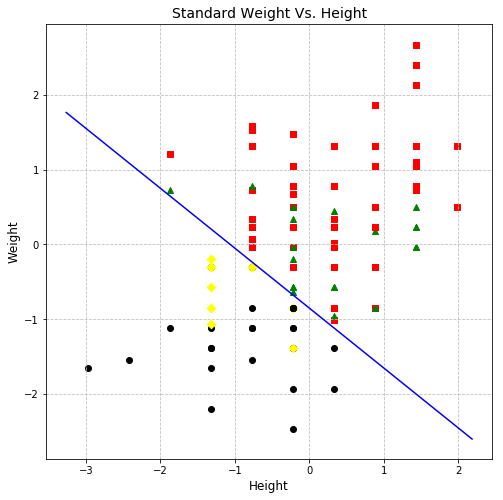

In [54]:
plot_separated(std_bball, y_bball, w, b)

__A6.__ _(5 pts)_ Now, most of all we'll want to reduce the number of points $x$ for which our prediction $\hat{y}$ has a different sign from the true label $y$. In these (bad) cases, one will have $y\hat{y} < 0$.

However, 'edge cases' are bad, too, and since we've provided our points with unit ($y = \pm 1$) labels it's also important to pay attention to points whose prediction have correct sign ($y\hat{y} > 0$), but are close to the boundary (here, within one unit):

$$
y(w\cdot x + b) = y\hat{y} < 1
$$

Thus, our objective function will seek to _maximize_ the distance between our $(w,b)$ separating line (plane) and 'bad' points holding the relationship $y(w\cdot x + b) = y\hat{y} < 1$. So, for a given plane $(w,b)$ and $n$ `data` points $x_i: i=1,\cdots n$, we'll be working with a subset of $k$ 'bad' points: $x_{i_\ell}:\ell=1,\cdots k$. To identify these, write a function:

- `bad_points(data, y, w, b)`

that takes `data` of $n$ rows and $m$ columns/features, line-defining parameters $w$ (a vector of $m$) and $b$ (a scalar), and outputs a boolean mask positively identifying the 'bad points' using a boolean mask, i.e., those for which:

$$
y(w\cdot x + b) = y\hat{y} < 1
$$

Note: this function is very similar to the requested `separated()` in __A4__.

When this is complete, exhibit this function's output using the line you selected in __A3__.

In [55]:
def bad_points(data, y, w, b):
    x_ = data['Height']
    y_ = data['Weight']
    #calulate y_hat
    y_hat = (w.dot(np.array([x_, y_]))) + b
    #make the mask
    mask = y*y_hat < 1
    return list(mask)

In [56]:
bad_points_mask = bad_points(std_bball, y_bball, w, b)

In [57]:
print(bad_points_mask)

[True, False, False, True, False, False, True, True, False, True, False, True, False, False, False, True, True, True, False, False, True, False, True, False, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, False, True, False, True, True, False, True, False, False, False, False, False, True, True, True, True, True, True, True, False, False, True, False, False, True, True, False, False, False, True, False, True, True, False, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, False, True, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, False, False, False, False, False]


In [58]:
def plot_bad_points(data, y, w, b):
    #get the boolean mask from seperated function
    bad_mask = bad_points(data, y, w, b)
    #initialize the plot:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_title("Standard Weight Vs. Height",fontsize=14)
    ax.set_xlabel("Height", fontsize=12)
    ax.set_ylabel("Weight", fontsize=12)
    ax.grid(True, linestyle='--', color = '0.75')
    ########################################Modified section:#######################
    #make the colors and markers:
    colors= ['red' if l == 1 else 'black' for l in y]
    marker = [u"s" if l == 1 else u"o" for l in y]
    for i, mask in enumerate(bad_mask):
        if mask:
            colors[i] = 'pink'
        else:
            pass
    ###################################rest is the same as before###################
    #define x and y of the data
    x_ = data['Height']
    y_ = data['Weight']
    #define the slope and intercept:
    intercept = -b / w[1]
    slope = -w[0] / w[1]
    #calculate x and y for the line:
    xx = np.linspace(1.1*data['Height'].min(), 1.1*data['Height'].max())
    yy = (slope * xx) + intercept
    #plot data points:
    for mark, col, _x, _y in zip(marker, colors, x_, y_):
        plt.scatter(_x, _y, marker = mark, c = col)
    #plot the line
    plt.plot(xx, yy, 'k-', c = 'b')
    return 

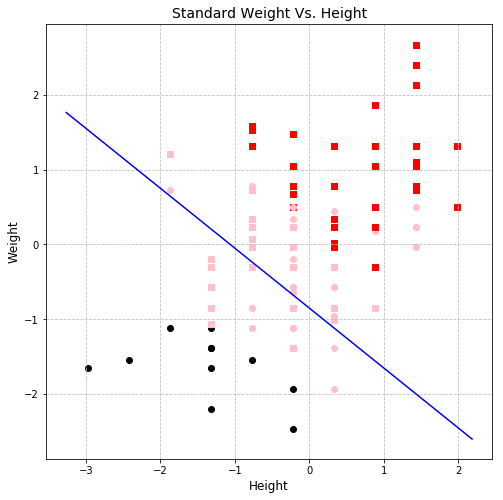

In [59]:
plot_bad_points(std_bball, y_bball, w, b)

__A6.__ _(4 pts)_ "How bad" a point is, is defined by distance&mdash;between our line (hyperplane) and the point. For a given point $x$ and line defined by $w$ and $b$, the distance is:
$$
d(x;w, b) = \frac{|w\cdot x + b|}{\|w\|}
$$
But since being on the wrong side (having the wrong sign) is extra bad, it's actually the signed distances we care about:
$$
d(x;w, b)_\text{sgn} =\frac{y(w\cdot x + b)}{\|w\|}
$$
This makes the sum of signed distances for the 'bad points' we've found into our objective function, which we'll aim to maximize:
$$
\begin{align*}
   D (X; w, b) 
   = &\sum_{\ell=1}^k d_\text{sgn}(x_{i_\ell};w, b) \\
   = &\sum_{\ell=1}^k \frac{y_{i_\ell}(w\cdot x_{i_\ell}+ b)}{\|w\|}
\end{align*}
$$

Since this is our objective function, express it's gradient components with respect to the parameters $b$ and $w_j$ (for any $j$ of the $m$ features) in the response box below.

<font color=blue>
$$
\nabla_b(D) = \sum_{\ell=1}^k \frac{y_{i_\ell}}{\|w\|}\\
$$ 
$$
\nabla_{w_j}(D) = \sum_{\ell=1}^k \frac{y_{i_\ell}x_{i_{j}}}{\|w\|}
$$
</font>

__A7.__ _(5 pts)_ Now that we have a formula for our gradient, it's time to write a function that computes it for an arbitrary set of points and plane. Use your above formulae to write a function:

- `gradient(data, y, w , b)`

that takes $w$, $b$, and a `data` matrix of $x_i$ rows, and computes the gradient for the $m + 1$ parameters.

When complete, exhibit this function's output using the line you exhibited in __A3__.

In [60]:
def gradient(data, y, w , b):
    norm = np.linalg.norm(w)
    g_b = sum(y/norm) #with respect to b
    g_w = sum((np.array(data)*y[:,None])/norm) #for all wjs
    return g_b, g_w

In [61]:
g_b, g_w = gradient(std_bball, y_bball, w, b)

In [62]:
g_b, g_w

(18.740851426632727,
 array([21.777772507463155, 55.79897293395546], dtype=object))

__A8.__ _(10 pts)_ Finally, it's time to pull things together into a gradient descent application. Specifically, create a function called 
- `SVM_GD(data, y, w, b, eta=0.001, iter_num=1000, threshold=0.001)`
that accepts the following arguments:

- `data`: a matrix of $n$ row/data points by $m$ feature/columns
- `y`:  an array of $n$ $\pm 1$ valued 'labels'
- `w`, `b`: an array of initial weights and an intercept (initial parameters) 
- `eta=0.001`: the 'learning rate' i.e., 'sensitivity' knob
- `iter_num=1000`: the max number of gradient steps to take before terminating
- `threshold=0.001`: a fixed, minimum distance that when steps fall below terminates the algorithm

To correctly implement, your code must do the following:
1. loop over `iter_num` steps
2. compute $w$ and $b$ gradient components
3. determinie $w$ and $b$ steps sizes
4. update $w$ and $b$ by _adding_ gradient components (this is technically ascent)
5. terminate if `iter_num` steps are complete or if the most recent step is smaller than `threshold`
6. `return` a list of the history of $w$ and $b$ values

When this is complete, apply your code to the standardized `bball` data and labels starting with your selected line from __A3__, and print the final parameters and whether or not your code converged, i.e., the threshold was met.

In [63]:
def SVM_GD(data, y, w, b, eta=0.001, iter_num=1000, threshold=0.001):
    ws = [w]
    bs = [b]
    for i in range(iter_num):
        #get gradient:
        g_b, g_w = gradient(data, y, w , b)
        #step sizes:
        delta_b = eta*g_b
        delta_w = eta*g_w
        #save log:
        #update w and b:
        w = w + delta_w
        ws.append(w)
        b = b + delta_b
        bs.append(b)
        #break if converged
        if np.sqrt((np.linalg.norm(delta_w)-delta_b**2)) < threshold:
            print(i)
    return ws, bs  

In [64]:
ws, bs = SVM_GD(std_bball, y_bball, w, b)

__A9.__ _(3 pts)_ Now, exhibit the final (best line) from your application in __A7__ using your `plot_separated()` function, report it's percent separated, and discuss if you think the line forms a better separation than the original line in the comment box below.

<font color=blue>Yes it does seperate the points better than the original point. Although we ran out of the maximum iteration number before the error was minimized. Therefore, if we increase the maximum number of iterations we could probably get a better seperated set of points.</font> 

In [66]:
y_mask_opt = separated(std_bball, y_bball, ws[-1], bs[-1])

In [67]:
print("Percentage of correctly seperated points: \n")
print(100*sum(y_mask_opt)/len(y_mask_opt))

Percentage of correctly seperated points: 

72.65625


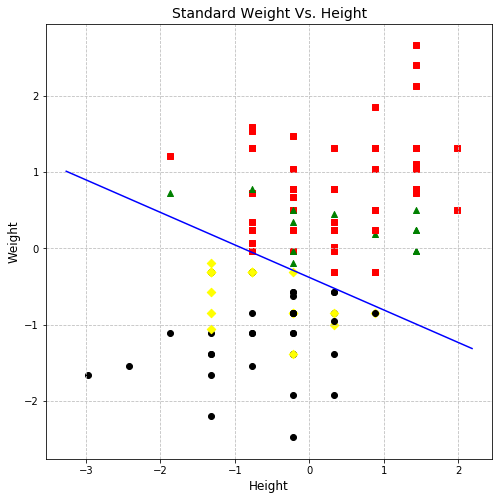

In [68]:
plot_separated(std_bball, y_bball, ws[-1], bs[-1])

__A10.__ (5 pts) As a last step, modify `plot_data_boundary()` again, but now into a new function called `plot_convergence()` that accepts the full history of `ws` and `bs` that were output by you `SVM_GD` function in __A7.__ and exhibits all lines corresponding to the steps along the way to convergence. Use the output of this code to discuss in the comment box below if you believe your code is converging towards a good-separating solution.

\[Hint. Use changing alpha or a colormap to help illustrate thr transition between values of $w$ and $b$\].

<font color=blue>Algorythm converges to the best seperating line although if we reach the minimum error in one direction, we may miss another local minimum error which can be an absalute minimum. It works well for finding a general well seperating line rather than the best possible line.</font>

In [72]:
def plot_convergence(data, y, ws, bs):
    plot_data_boundary(data, y)
    #######################################################
    x_ = data['Height']
    xx = np.linspace(1.1*x_.min(), 1.1*x_.max())#set the limit for the line
    for i in range(len(bs)):
        #define the slope and intercept:
        intercept = -bs[i] / ws[i][1]
        slope = -ws[i][0] / ws[i][1]
        #######################################################
        yy = (slope * xx) + intercept
        #######################################################
        #plot the line
        plt.plot(xx, yy, 'k-', c = 'b', alpha = 0.2)

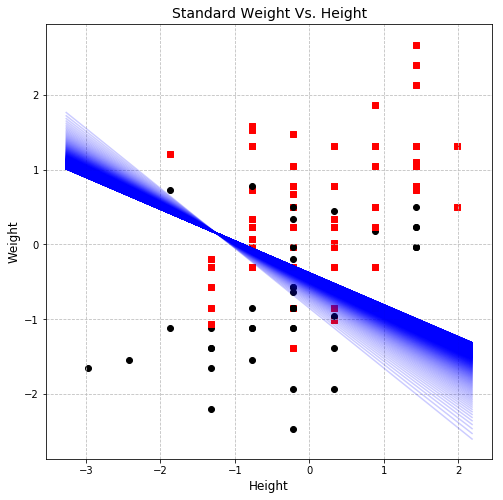

In [73]:
plot_convergence(std_bball, y_bball, ws, bs)